C:\Users\Ayush_trainee\AppData\Local\Temp\ipykernel_8200\1697038446.py:23: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  device_time = datetime.utcfromtimestamp(record["device_t"])  # Convert timestamp to datetime
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


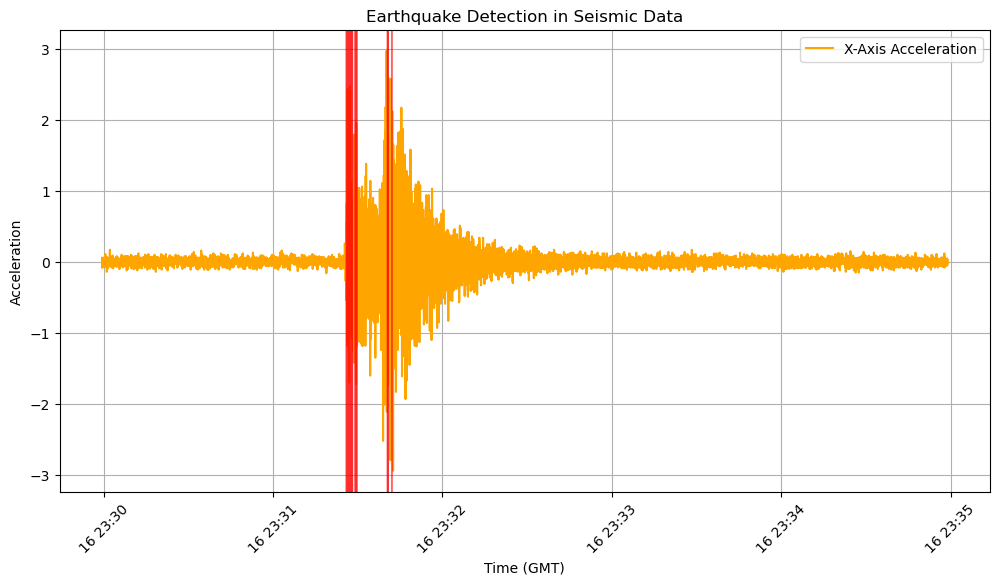

In [10]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis, mode, zscore
from obspy.signal.trigger import classic_sta_lta
from sklearn.preprocessing import RobustScaler
import joblib

# Load trained model and scaler
sgd_clf = joblib.load("sgd_classifier_model_updated.pkl")  # Ensure path is correct
scaler = joblib.load("scaler_updated.pkl")

# Load JSON file
json_file = "AWS EARTHQUAKE DATASET/date=2022-01-16 time=23-31-08/005/30.jsonl"  # Path to your JSON file
x_data, time_data = [], []

with open(json_file, "r") as file:
    for line in file:
        record = json.loads(line)
        device_time = datetime.utcfromtimestamp(record["device_t"])  # Convert timestamp to datetime
        sr = record["sr"]  # Sampling rate
        
        duration = len(record["x"]) / sr
        time_values = [device_time - timedelta(seconds=(duration - i / sr)) for i in range(len(record["x"]))]

        x_data.extend(record["x"])
        time_data.extend(time_values)

# Convert to numpy arrays
x_data = np.array(x_data)
time_data = np.array(time_data)

# Compute STA/LTA
sta_window = int(1 * sr)  # 1-second STA window
lta_window = int(10 * sr)  # 10-second LTA window
sta_lta_x = classic_sta_lta(x_data, sta_window, lta_window)

# Compute Modified Energy Ratio (MER)
def compute_mer(signal, window_size=50):
    energy = np.convolve(signal**2, np.ones(window_size), mode='valid')
    mer = np.zeros(len(signal))
    mer[window_size - 1: window_size - 1 + len(energy)] = energy
    return mer

mer_x = compute_mer(x_data, window_size=50)

# Identify STA/LTA threshold exceedance points
threshold_indices = np.where(sta_lta_x >= 3)[0]

# Prepare feature dataset
feature_list = []
prediction_timestamps = []

for idx in threshold_indices:
    if idx < int(1 * sr) or idx + int(3 * sr) >= len(x_data):
        continue  # Ensure valid window range
    
    threshold_time = time_data[idx]  # Get timestamp of threshold crossing
    
    before_start = idx - int(1 * sr)
    after_end = idx + int(3 * sr)
    
    before_data = x_data[before_start:idx]
    after_data = x_data[idx:after_end]
    before_sta_lta = sta_lta_x[before_start:idx]
    after_sta_lta = sta_lta_x[idx:after_end]
    before_mer = mer_x[before_start:idx]
    after_mer = mer_x[idx:after_end]
    
    def compute_stats(data, sta_lta, mer):
        if len(data) == 0:  # Handle empty case
            return [np.nan] * 14
        
        mode_value = mode(data, keepdims=True)[0]  # Ensure mode is an array
        return [
            np.mean(data), np.median(data), mode_value[0] if mode_value.size > 0 else np.nan, np.std(data),
            skew(data), kurtosis(data), np.var(data), np.max(data), np.min(data),
            np.mean(zscore(data)), np.mean(sta_lta), np.max(sta_lta),
            np.mean(mer), np.max(mer)
        ]
    
    before_stats = compute_stats(before_data, before_sta_lta, before_mer)
    after_stats = compute_stats(after_data, after_sta_lta, after_mer)

    feature_list.append(before_stats + after_stats)  # Stack before & after features
    prediction_timestamps.append(threshold_time)

# Convert features to numpy array and scale
feature_array = np.array(feature_list)

if feature_array.shape[0] > 0:  # Ensure we have samples to predict
    feature_array_scaled = scaler.transform(feature_array)

    # Make predictions
    predictions = sgd_clf.predict(feature_array_scaled)

    # Identify timestamps with predicted earthquake (label = 1)
    predicted_times = [prediction_timestamps[i] for i, label in enumerate(predictions) if label == 1]

    # Plot waveform
    plt.figure(figsize=(12, 6))
    plt.plot(time_data, x_data, color="orange",alpha=1, label="X-Axis Acceleration")
    
    # Mark predicted earthquake points with red vertical lines
    for t in predicted_times:
        plt.axvline(x=t, color="red",alpha=0.2, linestyle="-", linewidth=0.5)

    plt.xlabel("Time (GMT)")
    plt.ylabel("Acceleration")
    plt.title("Earthquake Detection in Seismic Data")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()
else:
    print("No valid feature windows found for prediction.")


C:\Users\Ayush_trainee\AppData\Local\Temp\ipykernel_8200\2740267432.py:25: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  device_time = datetime.utcfromtimestamp(record["device_t"])  # Convert timestamp to datetime
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(



Detected Earthquake Events in JSON Data:

{
    "country_code": "mx",
    "device_id": "005",
    "x": [
        0.03,
        0,
        0,
        0.17,
        0.26,
        0.2,
        0.13,
        -0.02,
        -0.09,
        -0.04,
        0.01,
        0.08,
        -0.04,
        -0.27,
        -0.17,
        -0.05,
        0,
        0.2,
        -0.22,
        -0.51,
        -0.54,
        -0.12,
        0.55,
        0.49,
        0.33,
        0.83,
        0.43,
        -0.49,
        -0.19,
        -0.43,
        -1.01,
        -0.99
    ],
    "y": [
        0.05,
        0.04,
        0.05,
        0,
        -0.02,
        -0.08,
        0.02,
        -0.07,
        -0.07,
        0.06,
        0.04,
        0,
        0.01,
        -0.11,
        -0.15,
        -0.18,
        -0.17,
        -0.1,
        -0.09,
        -0.07,
        -0.04,
        0.06,
        0.09,
        0.05,
        -0.04,
        -0.01,
        -0.04,
        0.03,
        0.21,
        0.

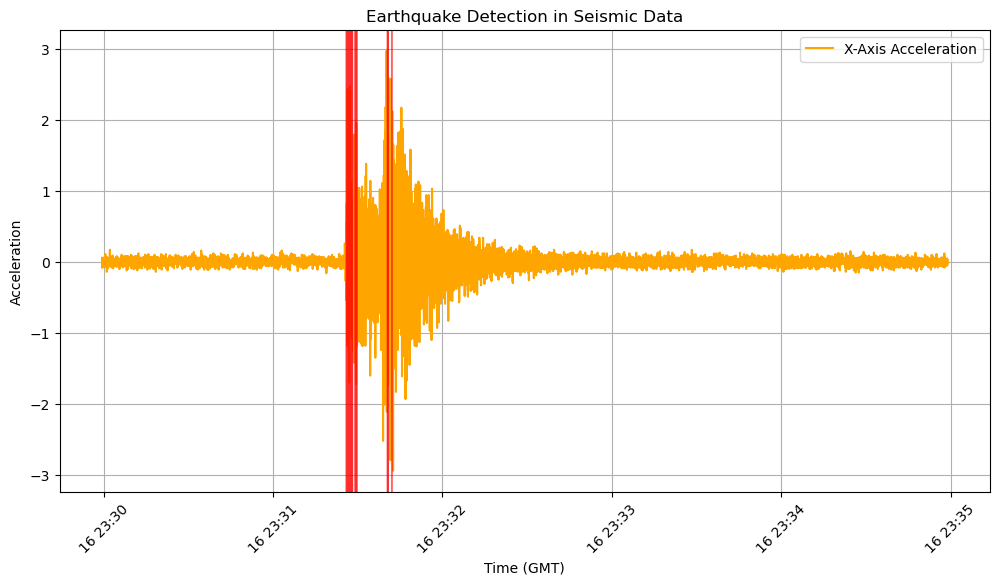

In [12]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis, mode, zscore
from obspy.signal.trigger import classic_sta_lta
from sklearn.preprocessing import RobustScaler
import joblib

# Load trained model and scaler
sgd_clf = joblib.load("sgd_classifier_model_updated.pkl")  # Ensure path is correct
scaler = joblib.load("scaler_updated.pkl")


# Load JSON file
json_file = "AWS EARTHQUAKE DATASET/date=2022-01-16 time=23-31-08/005/30.jsonl"  # Path to your JSON file
x_data, time_data, original_json_data = [], [], []

with open(json_file, "r") as file:
    for line in file:
        record = json.loads(line)
        original_json_data.append(record)  # Store full JSON entry for reference
        device_time = datetime.utcfromtimestamp(record["device_t"])  # Convert timestamp to datetime
        sr = record["sr"]  # Sampling rate
        
        duration = len(record["x"]) / sr
        time_values = [device_time - timedelta(seconds=(duration - i / sr)) for i in range(len(record["x"]))]

        x_data.extend(record["x"])
        time_data.extend(time_values)

# Convert to numpy arrays
x_data = np.array(x_data)
time_data = np.array(time_data)

# Compute STA/LTA
sta_window = int(1 * sr)  # 1-second STA window
lta_window = int(10 * sr)  # 10-second LTA window
sta_lta_x = classic_sta_lta(x_data, sta_window, lta_window)

# Compute Modified Energy Ratio (MER)
def compute_mer(signal, window_size=50):
    energy = np.convolve(signal**2, np.ones(window_size), mode='valid')
    mer = np.zeros(len(signal))
    mer[window_size - 1: window_size - 1 + len(energy)] = energy
    return mer

mer_x = compute_mer(x_data, window_size=50)

# Identify STA/LTA threshold exceedance points
threshold_indices = np.where(sta_lta_x >= 3)[0]

# Prepare feature dataset
feature_list = []
prediction_timestamps = []

for idx in threshold_indices:
    if idx < int(1 * sr) or idx + int(3 * sr) >= len(x_data):
        continue  # Ensure valid window range
    
    threshold_time = time_data[idx]  # Get timestamp of threshold crossing
    
    before_start = idx - int(1 * sr)
    after_end = idx + int(3 * sr)
    
    before_data = x_data[before_start:idx]
    after_data = x_data[idx:after_end]
    before_sta_lta = sta_lta_x[before_start:idx]
    after_sta_lta = sta_lta_x[idx:after_end]
    before_mer = mer_x[before_start:idx]
    after_mer = mer_x[idx:after_end]
    
    def compute_stats(data, sta_lta, mer):
        if len(data) == 0:  # Handle empty case
            return [np.nan] * 14
        
        mode_value = mode(data, keepdims=True)[0]  # Ensure mode is an array
        return [
            np.mean(data), np.median(data), mode_value[0] if mode_value.size > 0 else np.nan, np.std(data),
            skew(data), kurtosis(data), np.var(data), np.max(data), np.min(data),
            np.mean(zscore(data)), np.mean(sta_lta), np.max(sta_lta),
            np.mean(mer), np.max(mer)
        ]
    
    before_stats = compute_stats(before_data, before_sta_lta, before_mer)
    after_stats = compute_stats(after_data, after_sta_lta, after_mer)

    feature_list.append(before_stats + after_stats)  # Stack before & after features
    prediction_timestamps.append(threshold_time)

# Convert features to numpy array and scale
feature_array = np.array(feature_list)

if feature_array.shape[0] > 0:  # Ensure we have samples to predict
    feature_array_scaled = scaler.transform(feature_array)

    # Make predictions
    predictions = sgd_clf.predict(feature_array_scaled)

    # Identify timestamps with predicted earthquake (label = 1)
    predicted_times = [prediction_timestamps[i] for i, label in enumerate(predictions) if label == 1]

    # Find corresponding JSON entry for each predicted timestamp
    predicted_json_entries = []
    for t in predicted_times:
        closest_idx = np.argmin(np.abs(time_data - t))  # Find closest timestamp index
        closest_json_record = original_json_data[closest_idx // len(original_json_data[0]["x"])]  # Map to original JSON entry
        predicted_json_entries.append(closest_json_record)
    
    # Print JSON entries where earthquake is detected
    print("\nDetected Earthquake Events in JSON Data:\n")
    for entry in predicted_json_entries:
        print(json.dumps(entry, indent=4))  # Pretty print JSON

    # Plot waveform
    plt.figure(figsize=(12, 6))
    plt.plot(time_data, x_data, color="orange", label="X-Axis Acceleration")
    
    # Mark predicted earthquake points with red vertical lines
    for t in predicted_times:
        plt.axvline(x=t, color="red", linestyle="-",alpha=0.2, linewidth=0.5)

    plt.xlabel("Time (GMT)")
    plt.ylabel("Acceleration")
    plt.title("Earthquake Detection in Seismic Data")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()
else:
    print("No valid feature windows found for prediction.")
